<a href="https://colab.research.google.com/github/asympson/diabetes_finalproject_D4project/blob/main/MNIST_classificationAustinEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple CNN model for MNIST classification
This notebook contains a simple CNN model to perform classification of Handwritten digits using the MNIST dataset. PyTorch is used to build the model and train it. This notebook was created as part of COM S 571X : Responsible AI: Risk Management in Data Driven Discovery.

Versions of the libraries used in this notebook:
```
PyTorch version: 1.13.1
Torchvision version: 0.14.1
Torchsummary version: 1.5.1
Numpy version: 1.22.3
Tqdm version: 4.64.0
Matplotlib version: 3.5.2
```

## Importing the required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm.notebook import tqdm
import torchsummary

print(f"Successfully imported all the libraries")

Successfully imported all the libraries


## Define Hyperparameters

In [21]:
batch_size = 64
epochs = 10
lr = 0.01
momentum = 0.9
weight_decay = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Hyperparameters are defined")


Hyperparameters are defined


## Create Dataset and DataLoader

In [4]:
# Augmentations to be applied on the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Augmentations to be applied on the test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create the training and test datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transform)

# Create the training and test loaders which will be used to load the data in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Your training set contains: {len(train_dataset)} images")
print(f"Your test set contains: {len(test_dataset)} images")


100%|██████████| 9912422/9912422 [00:00<00:00, 134689147.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64778445.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36268860.51it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5724317.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Your training set contains: 60000 images
Your test set contains: 10000 images


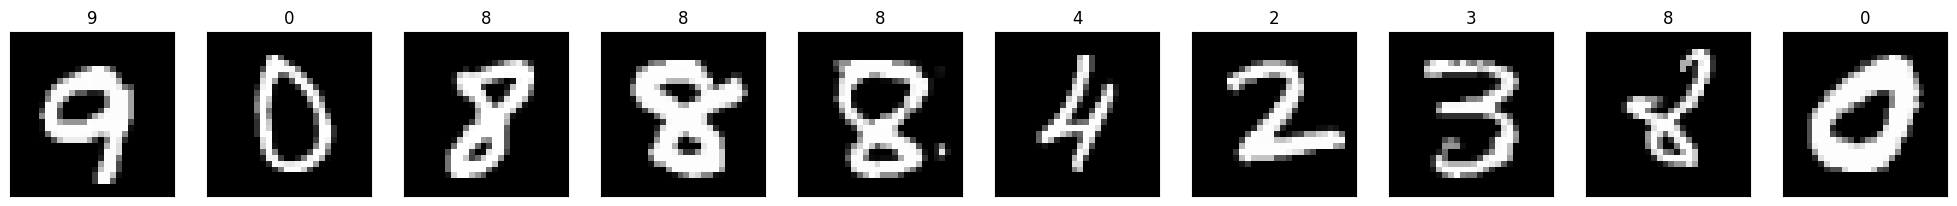

In [5]:
# Test the data loader
images, labels = next(iter(train_loader))

# Plot the images in the batch, along with the labels
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(str(labels[i].item()))

## Define our Training Loop and Test Loop

In [6]:
def train(model,train_loader,epochs):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)

    for epoch in range(1, epochs+1):
        # Set the model to train mode
        model.train()

        # Keep track of the loss
        train_loss = 0.0

        # Keep track of accuracy
        train_acc = 0.0

        # Iterate over the training batches
        for data, target in tqdm(train_loader,desc = 'Epoch '+str(epoch), unit = 'b'):
            # Zero the gradients
            optimizer.zero_grad()

            # Load the data onto the device
            data = data.to(device)

            # Load the labels onto the device
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Do a backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the loss
            train_loss += loss.item()*data.size(0)

            # Calculate the accuracy
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item()*data.size(0)

        # Calculate the average loss and accuracy
        train_loss = train_loss/len(train_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(
            epoch, train_loss, train_acc))

def test(model,test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()

        # Iterate over the test data and generate predictions
        for data, target in tqdm(test_loader,desc = 'Testing', unit = 'b'):
            # Load the data onto the device
            data = data.to(device)

            # Load the labels onto the device
            target = target.to(device)


            # Generate output
            output = model(data)

            # Set total and correct
            _, pred = torch.max(output, dim=1)
            correct += torch.sum(pred == target).item()
            total += data.size(0)

        print('Accuracy on test set: %d %%' % (100 * correct / total))



## Define our Model
For this example, we will use a simple LeNet-5 architecture.

In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutional layers
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(16*8*8, 120) # 8x8x16 -> 120
        self.fc2 = nn.Linear(120, 84) # 120 -> 84
        self.fc3 = nn.Linear(84, 10) # 84 -> 10

        # Activation functions
        self.activation = nn.ELU()

    def forward(self, x):
        # pass data through conv1
        x = self.conv1(x) # 1x28x28 -> 6x24x24
        x = self.activation(x)

        # pass data through pool
        x = self.pool(x) # 6x24x24 -> 6x12x12

        # pass data through conv2
        x = self.conv2(x) # 6x12x12 -> 16x8x8
        x = self.activation(x)

        # Flatten the input
        x = x.view(x.size(0), -1) # 16x8x8 -> 1024

        # pass data through The fully connected layers
        x = self.fc1(x) # 1024 -> 120
        x = self.fc2(x) # 120 -> 84
        x = self.fc3(x) # 84 -> 10

        return x


model = LeNet().to(device)


print(f"Successfully Created a Model! \n Here are the details")

torchsummary.summary(model, (1, 28, 28))




Successfully Created a Model! 
 Here are the details
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
               ELU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
               ELU-5             [-1, 16, 8, 8]               0
            Linear-6                  [-1, 120]         123,000
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 136,586
Trainable params: 136,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.52
Estimated Total Size (MB): 0.60
------------------------------------------------------

## Train the Model

In [23]:
train(model,train_loader,epochs)
print(f"Training Complete!")
test(model,test_loader)
print(f"Testing Complete!")

Epoch 1:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 1 	Training Loss: 0.228547 	Training Accuracy: 0.932883


Epoch 2:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 2 	Training Loss: 0.069914 	Training Accuracy: 0.978433


Epoch 3:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 3 	Training Loss: 0.052508 	Training Accuracy: 0.983583


Epoch 4:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 4 	Training Loss: 0.044052 	Training Accuracy: 0.986633


Epoch 5:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 5 	Training Loss: 0.036808 	Training Accuracy: 0.988200


Epoch 6:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 6 	Training Loss: 0.032363 	Training Accuracy: 0.989717


Epoch 7:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 7 	Training Loss: 0.028772 	Training Accuracy: 0.990783


Epoch 8:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 8 	Training Loss: 0.025918 	Training Accuracy: 0.991683


Epoch 9:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 9 	Training Loss: 0.023984 	Training Accuracy: 0.992033


Epoch 10:   0%|          | 0/938 [00:00<?, ?b/s]

Epoch: 10 	Training Loss: 0.021658 	Training Accuracy: 0.992883
Training Complete!


Testing:   0%|          | 0/157 [00:00<?, ?b/s]

Accuracy on test set: 98 %
Testing Complete!


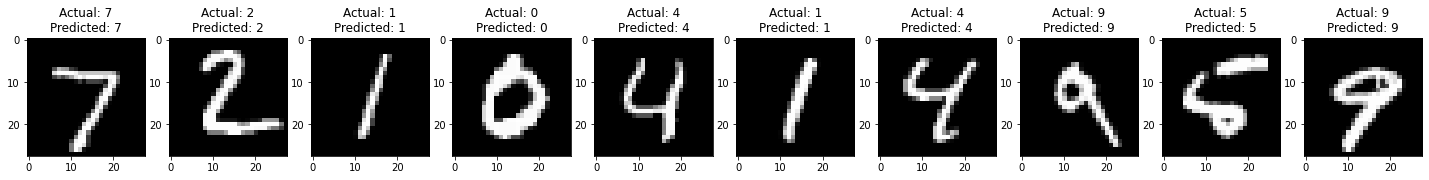

In [ ]:
test_images, test_labels = next(iter(test_loader))

test_images = test_images.to(device)

# Get predictions
pred = model(test_images)

plt.figure(figsize=(25, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    ax.imshow(test_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Actual: {test_labels[i]}\nPredicted: {torch.argmax(pred[i])}")

## Save the Model
We will be saving the entire model (architecture + weights + optimizer state) to a file.

In [ ]:
torch.save(model,'mnist_'+time.strftime("%Y-%m-%d")+'.pt')

> Next time you want to load the saved model, use the following command
```python
model = torch.load('filepath')
```